In [ ]:
!pip install langchain==0.3.24 -q
!pip install langchain-openai -q
!pip install langchain_chroma -q
!pip install langchain_community -q
!pip install langgraph -q
!pip install pypdf -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.5/438.5 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 4.8 MB/s eta 0:00:0

In [ ]:
import os
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage, ToolMessage
from operator import add as add_messages
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_core.tools import tool

In [ ]:
import os
from google.colab import userdata

os.environ['OPENAI_API_KEY'] = userdata.get('API_KEY')

In [ ]:
llm = ChatOpenAI(
    model="gpt-4o", temperature = 0)

In [ ]:
embeddings = OpenAIEmbeddings(
    model="text-embedding-3-small",
)

In [ ]:
pdf_loader = PyPDFLoader("/content/codeprolk.pdf")

In [ ]:
pages = pdf_loader.load()

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

In [ ]:
pages_split = text_splitter.split_documents(pages)

In [ ]:
len(pages_split)

9

In [ ]:
vectorstore = Chroma.from_documents(
    documents=pages_split,
    embedding=embeddings,
    persist_directory="./vectorstore",
    collection_name="data"
)

In [ ]:
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3}
)

In [ ]:
@tool
def retriever_tool(query: str) -> str:
    """
    This tool searches and returns the information about codepro lk.
    """
    docs = retriever.invoke(query)
    if not docs:
        return "I found no relevant information"
    results = []
    for i, doc in enumerate(docs):
        results.append(f"Document {i+1}:\n{doc.page_content}")

    return "\n\n".join(results)

In [ ]:
tools = [retriever_tool]

llm_with_tools = llm.bind_tools(tools)

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [ ]:
def should_continue(state: AgentState):
    """Check if the last message contains tool calls."""
    result = state['messages'][-1]
    return hasattr(result, 'tool_calls') and len(result.tool_calls) > 0

In [ ]:
system_prompt = """
You are an intelligent AI assistant who answers questions about codeprolk based on the PDF document loaded into your knowledge base.
Use the retriever tool available to answer questions about the given data. You can make multiple calls if needed.
If you need to look up some information before asking a follow up question, you are allowed to do that!
Please always cite the specific parts of the documents you use in your answers.
"""

In [ ]:
tools_dict = {our_tool.name: our_tool for our_tool in tools}

In [ ]:
# LLM Agent
def call_llm(state: AgentState) -> AgentState:
    """Function to call the LLM with the current state."""
    messages = list(state['messages'])
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm_with_tools.invoke(messages)
    print(message)
    return {'messages': [message]}

In [ ]:
# Retriever Agent
def take_action(state: AgentState) -> AgentState:
    """Execute tool calls from the LLM's response."""

    tool_calls = state['messages'][-1].tool_calls
    results = []
    for t in tool_calls:
        print(f"Calling Tool: {t['name']} with query: {t['args'].get('query', 'No query provided')}")

        if not t['name'] in tools_dict: # Checks if a valid tool is present
            print(f"\nTool: {t['name']} does not exist.")
            result = "Incorrect Tool Name, Please Retry and Select tool from List of Available tools."

        else:
            result = tools_dict[t['name']].invoke(t['args'].get('query', ''))
            print(f"Result length: {len(str(result))}")


        # Appends the Tool Message
        results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))

    print("Tools Execution Complete. Back to the model!")
    return {'messages': results}

In [ ]:
workflow = StateGraph(AgentState)

workflow.add_node("llm", call_llm)
workflow.add_node("retriever_agent", take_action)

workflow.add_edge(START, "llm")
workflow.add_conditional_edges(
    "llm",
    should_continue,
    {True: "retriever_agent", False: END}
)
workflow.add_edge("retriever_agent", "llm")

app = workflow.compile()

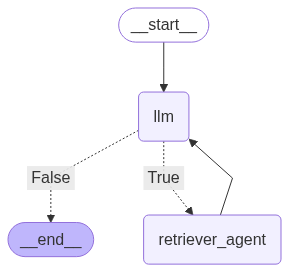

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
result = app.invoke({"messages": [HumanMessage(content="what are the courses offer codeprolk")]})

content='' additional_kwargs={'tool_calls': [{'id': 'call_CCkUCupmgJTttpCnxsMYsGg9', 'function': {'arguments': '{"query":"courses offered by CodeProLK"}', 'name': 'retriever_tool'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 142, 'total_tokens': 163, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BdW6GV54SOXCn9ohHtFkh45PTOAFP', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--789752c7-ba6f-42a4-a4fe-e9a779f93242-0' tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'courses offered by CodeProLK'}, 'id': 'call_CCkUCupmgJTttpCnxsMYsGg9', 'type': 'tool_call'}] usage_metadata={'input_tokens': 142, 'output_tokens': 21, 'total_tokens'

In [ ]:
result['messages'][-1].content

"CodeProLK offers a variety of technology-related courses in Sinhala, catering to different proficiency levels from beginners to intermediates. Some of the key courses include:\n\n1. **Python GUI – Tkinter**: This course covers the essentials of creating graphical user interfaces using Python's Tkinter library.\n2. **Machine Learning Projects**: This includes practical projects like Sentiment Analysis and Laptop Price Predictor.\n3. **Data Structures and Algorithms**: A comprehensive guide to essential programming concepts and problem-solving techniques.\n\nThese courses are designed to provide a holistic learning experience with video lectures, quizzes, and assignments to reinforce learning. They are all presented in Sinhala to make them accessible to the local community."

In [ ]:
result = app.invoke({"messages": [HumanMessage(content="what is blockchain")]})

content='' additional_kwargs={'tool_calls': [{'id': 'call_OwNHr8dWGIo3xxfp1RQ7teAM', 'function': {'arguments': '{"query":"blockchain"}', 'name': 'retriever_tool'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 137, 'total_tokens': 154, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BdW723yJshzgC3onPmQkfeEcZjt1e', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--76ba01a3-13d2-4258-b309-49c769328f7e-0' tool_calls=[{'name': 'retriever_tool', 'args': {'query': 'blockchain'}, 'id': 'call_OwNHr8dWGIo3xxfp1RQ7teAM', 'type': 'tool_call'}] usage_metadata={'input_tokens': 137, 'output_tokens': 17, 'total_tokens': 154, 'input_token_details': {'audi